In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from sklearn import metrics
from time import time
import numpy as np
import pandas as pd
from collections import OrderedDict
from manifold_helper import ManifoldHelper


rng = np.random.default_rng(seed=42)

def plot_images(data, n_img_per_row=10, cmap='gray'):
    # plot images of MNIST base
    shape = int(np.sqrt(len(data[0])))
    # plot iage of the digits
    img = np.zeros( (shape * n_img_per_row, shape * n_img_per_row) )
    for i in range( n_img_per_row ):
        ix = shape * i
        for j in range( n_img_per_row ):
            iy = shape * j
            img[ix:ix + shape, iy:iy + shape] = data[i * n_img_per_row + j].reshape( (shape, shape) )

    plt.figure(figsize=(15, 15))
    plt.imshow( img, cmap=cmap )
    plt.xticks( [] )
    plt.yticks( [] )
    plt.show()

In [2]:
n_class = 10 # n primeiros digitos
amostras = 3000
neighbors = [5, 8, 10, 12]
dimensions = [2, 3, 5, 10, 25, 50, 100]
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']

# Carregando os dados

In [3]:
datasetOriginal = pd.read_csv("data/mnist_train.csv")
df = datasetOriginal.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [5]:
# separar os rótulos dos dados
label, x = df.iloc[:, :1], df.iloc[:, 1:]
label = label.to_numpy().transpose()[0]
x = x.to_numpy()
label, x

(array([5, 0, 4, ..., 5, 6, 8], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

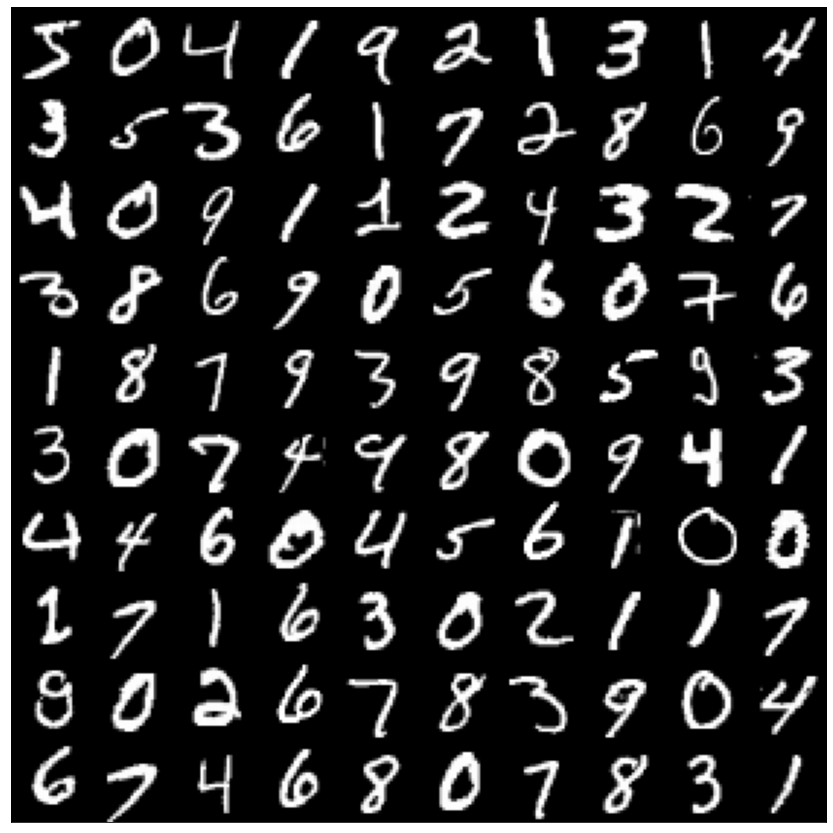

In [6]:
plot_images(x)

## Selecionando dados para analise

In [7]:
idx = np.argsort(label)
label = label[idx]
x = x[idx]

idx = np.random.RandomState(seed=42).permutation(len(x))
x = x[idx, :]
label = label[idx]
x_cut = x[:amostras, :]
label_cut = label[:amostras]

unique, counts = np.unique(label_cut, return_counts=True)
num_data_cut = dict(zip(unique, counts))
print(x_cut.shape)
num_data_cut

(3000, 784)


{0: 286,
 1: 353,
 2: 274,
 3: 316,
 4: 289,
 5: 290,
 6: 306,
 7: 307,
 8: 290,
 9: 289}

# ARI

Gerando os métodos para cada valor de vizinhos no intervalo

# Testes com várias quantidades de imagens

In [8]:
manifold = ManifoldHelper()

parametros = OrderedDict()
# ISOMAP: k = 8 e d = 25
parametros['ISOMAP'] = {'k': 8, 'd': 25}
# LLE: k = 5 e d = 25
parametros['LLE'] = {'k': 5, 'd': 25}
# Laplacian Eigenmaps: k = 5 e d = 10
parametros['SE'] = {'k': 5, 'd': 10}
# LTSA: k = 12 e d = 5
parametros['LTSA'] = {'k': 12, 'd': 5}

amostras = np.arange(1000, 12001, 1000)
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']
ari_results = OrderedDict()
time_results = OrderedDict()
for m in methods:
    ari_results[m] = np.zeros(len(amostras))
    time_results[m] = np.zeros(len(amostras))
    
for i in range(len(amostras)):
    x_cut = x[:amostras[i], :]
    label_cut = label[:amostras[i]]
    
    print(f'\nAmostras: {amostras[i]}')
    
    for m  in methods:
        k = parametros[m]['k']
        d = parametros[m]['d']
        t0 = time()
        Y = manifold.fit_transform(x_cut, m, k, d)
        gmm_predict = manifold._gmm_predict(Y, 10)
        t1 = time()
        
        ari_results[m][i] = metrics.adjusted_rand_score(gmm_predict, label_cut)
        time_results[m][i] = t1 - t0
        
        print(f' {ari_results[m][i]:.2f} ({time_results[m][i]:.1f}s) ', end='')

Using alternative LTSA.

Amostras: 1000
 0.49 (0.6s)  0.44 (0.6s)  0.45 (0.4s)  0.19 (2.0s) 
Amostras: 2000
 0.56 (2.4s)  0.49 (1.3s)  0.56 (0.7s)  0.28 (6.9s) 
Amostras: 3000
 0.61 (5.6s)  0.61 (2.8s)  0.65 (0.8s)  0.38 (17.6s) 
Amostras: 4000
 0.61 (10.7s)  0.58 (5.5s)  0.49 (1.3s)  0.18 (35.3s) 
Amostras: 5000
 0.58 (19.1s)  0.55 (9.9s)  0.56 (2.3s)  0.22 (61.3s) 
Amostras: 6000
 0.62 (31.5s)  0.59 (17.1s)  0.58 (2.4s)  0.28 (98.2s) 
Amostras: 7000
 0.57 (44.7s)  0.64 (26.2s)  0.57 (3.3s)  0.08 (143.6s) 
Amostras: 8000
 0.59 (62.3s)  0.57 (36.2s)  0.63 (4.0s)  0.07 (204.6s) 
Amostras: 9000
 0.55 (84.7s)  0.63 (48.1s)  0.68 (5.5s)  -0.00 (279.1s) 
Amostras: 10000
 0.52 (110.0s)  0.62 (64.2s)  0.68 (6.8s)  -0.00 (364.3s) 
Amostras: 11000
 0.65 (140.6s)  0.70 (83.6s)  0.69 (8.2s)  0.21 (468.3s) 
Amostras: 12000
 0.58 (175.7s)  0.68 (108.7s)  0.67 (9.7s)  0.03 (588.4s) 

In [9]:
def plot_ari_results_time(ari_results, method, title, color, marker):
    fig, ax1 = plt.subplots()
    plt.xticks(amostras, rotation=45, ha='center')
    plt.title(title)

    ax1.set_xlabel('Amostras (n)')
    ax1.set_ylabel('Adjusted Rand Index')
    ax1.plot(amostras, ari_results[method], color=color, marker=marker, label='ARI')
    ax1.set_yticks(np.arange(0, 1.01, 0.1))
    ax1.grid()

    ax2 = ax1.twinx()
    color = '#000000'
    ax2.set_ylabel('Tempo (s)', color=color)
    ax2.plot(amostras, time_results[method], color=color, marker='s', linestyle='dashed', label='Tempo')
    ax2.tick_params(axis='y', labelcolor=color)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    fig.tight_layout()
    plt.show()

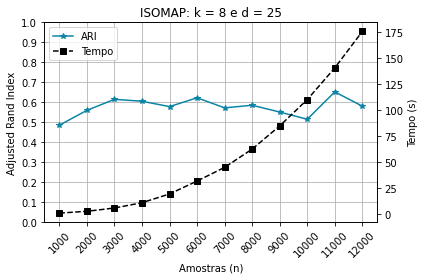

In [10]:
plot_ari_results_time(ari_results, 'ISOMAP', 'ISOMAP: k = 8 e d = 25', '#0b84a5', '*')

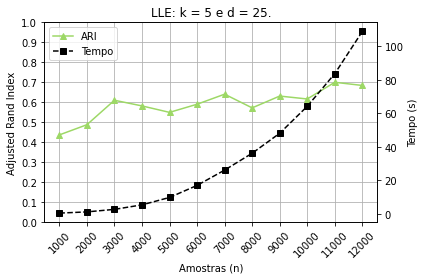

In [11]:
plot_ari_results_time(ari_results, 'LLE', 'LLE: k = 5 e d = 25.', '#9dd866', '^')

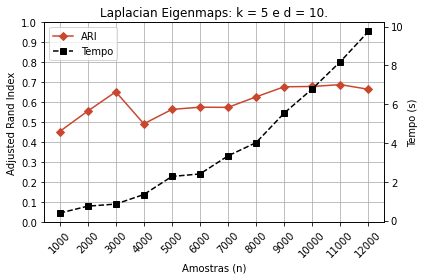

In [12]:
plot_ari_results_time(ari_results, 'SE', 'Laplacian Eigenmaps: k = 5 e d = 10.', '#ca472f', 'D')

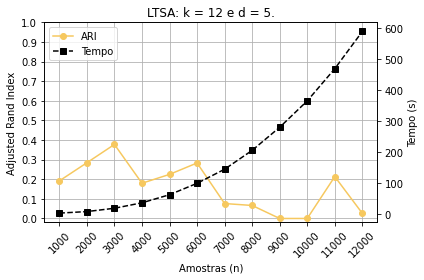

In [13]:
plot_ari_results_time(ari_results, 'LTSA', 'LTSA: k = 12 e d = 5.', '#f6c85f', 'o')

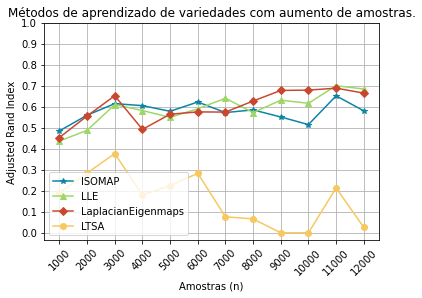

In [14]:
fig, ax1 = plt.subplots()
plt.xticks(amostras, rotation=45, ha='center')
plt.title('Métodos de aprendizado de variedades com aumento de amostras.')
    
ax1.set_xlabel('Amostras (n)')
ax1.set_ylabel('Adjusted Rand Index')

ax1.plot(amostras, ari_results['ISOMAP'], color='#0b84a5',marker='*', label='ISOMAP')
ax1.plot(amostras, ari_results['LLE'], color='#9dd866', marker='^', label='LLE')
ax1.plot(amostras, ari_results['SE'], color='#ca472f', marker='D', label='LaplacianEigenmaps')
ax1.plot(amostras, ari_results['LTSA'], color='#f6c85f', marker='o', label='LTSA')
ax1.set_yticks(np.arange(0, 1.01, 0.1))

plt.legend(loc=3)
plt.grid()
plt.show()

In [15]:
ari_media = OrderedDict()
for m in methods:
    ari_media[m] = np.mean(ari_results[m])
ari_media

OrderedDict([('ISOMAP', 0.5769738455120837),
             ('LLE', 0.5918816238395609),
             ('SE', 0.600652853432749),
             ('LTSA', 0.16022758772819531)])